# Import

In [1]:
# torch package
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


# dataset packagea
from torch.utils.data import Dataset, DataLoader
from tensorflow.keras.datasets import imdb
from sklearn.model_selection import train_test_split

# metrcis
from sklearn.metrics import accuracy_score, classification_report

# ETC
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Simple-RNN Model

In [2]:
class SimpleRNN_cell(nn.Module):
    def __init__(self, input_size, hidden_size, device):
        super().__init__()
        # input_size: X features(X's columns) 
        # if X.shape (batch_size, sequence_length, feature) then X.shape[2](feature)

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.device = device


        # 파라미터 생성 및 초기화
        # forward 내 tanh 인자값에 대한 연산으로 torch.matmul을 사용할 경우 아래 주석처리된 W_xh를 사용
        # self.W_xh = nn.Parameter(torch.empty(self.input_size, self.hidden_size, device=self.device))
        self.W_xh = nn.Parameter(torch.empty(self.hidden_size, self.input_size, device=self.device))
        self.W_hh = nn.Parameter(torch.empty(self.hidden_size, self.hidden_size, device=self.device))
        self.b_xh = nn.Parameter(torch.empty(self.hidden_size, device=self.device))
        self.b_hh = nn.Parameter(torch.empty(self.hidden_size, device=self.device))


        nn.init.xavier_uniform_(self.W_xh, gain=hidden_size**-1)
        nn.init.xavier_uniform_(self.W_hh, gain=hidden_size**-1)
        nn.init.constant_(self.b_xh, 1.)
        nn.init.constant_(self.b_hh, 1.)


    # tanh함수를 구현하였으나 torch cuda/cpu 연산처리 관련해서 복잡하므로 그냥 torch.tanh 사용
    def tanh(self, x):
        return (torch.exp(x) - torch.exp(-x))/(torch.exp(x) + torch.exp(-x))
    

    def forward(self, x, hidden=None): # x.shape: (batch_size, sequence_length, embeding_size)
        # init hidden state
        if hidden is None:
            hidden = torch.zeros(x.shape[0], self.hidden_size, device=self.device)


        # output.shape: (batch_size, sequence_length, hidden_size)
        outputs = []
        for seq in range(x.shape[1]):
            input_x = x[:,seq,:]
            hidden = torch.tanh(F.linear(input_x, self.W_xh, self.b_xh)  + F.linear(hidden, self.W_hh, self.b_hh))
            outputs.append(hidden.unsqueeze(1))

        outputs = torch.cat(outputs, dim=1)
        return outputs

$h_t = tanh(W_{xh} \cdot x_t + b_{xh} + W_{hh} \cdot h_{t-1} + b_{hh})$  

In [3]:
class SimpleRNN(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config


        self.embedding = nn.Embedding(num_embeddings=config.vocab_size,
                                     embedding_dim=config.em_output)
        
        # batch_size, sequence_size, embeding_size
        self.rnn_1 = SimpleRNN_cell(input_size=config.em_output,
                                    hidden_size=config.rnn_node1,
                                    device=config.device)
        
        self.drop_out = nn.Dropout(p=config.drop_out_rate)
        
        self.rnn_2 = SimpleRNN_cell(input_size=config.rnn_node1,
                                    hidden_size=config.rnn_node2,
                                    device=config.device)
        
        self.dense = nn.Linear(in_features=config.rnn_node2, out_features=1)


    def forward(self, x):
        ebd = self.embedding(x)
        rnn1_output = self.rnn_1(ebd)
        drop_layer = self.drop_out(rnn1_output)
        rnn2_output = self.rnn_2(drop_layer)
        drop_layer = self.drop_out(rnn2_output)
        dense_output = self.dense(drop_layer[:, -1, :])
        sigmoid_output = torch.sigmoid(dense_output)
        # final_output = (sigmoid_output > 0.5).float().view(-1)
        
        return sigmoid_output

# Train

In [4]:
def train(model, config, train, valid, optimizer=False, loss=False):
    train_loss_history = []
    valid_loss_history = []
    
    optimizer = optimizer if optimizer else optim.Adam(model.parameters(), lr=config.learning_rate)
    loss_function = loss if loss else nn.BCELoss()


    for i in range(config.epochs):
        train_loss_ = 0
        model.train()
        with torch.enable_grad():
            for feature, label in train:
                optimizer.zero_grad()
                outputs = model(feature).view(-1)
                loss = loss_function(outputs, label)
                # loss.requires_grad_(True)
                loss.backward()
                optimizer.step()

                train_loss_ += loss.item()

        train_loss_ /= config.batch_size
        train_loss_history.append(train_loss_)


        valid_loss_ = 0
        model.eval()
        with torch.no_grad():
            for feature, label in valid:
                outputs = model(feature)
                loss = loss_function(outputs.reshape(-1), label)
                
                valid_loss_ += loss.item()

        valid_loss_ /= config.batch_size
        valid_loss_history.append(valid_loss_)

        if (i+1)%int((config.epochs)*0.1)==0:
            print(f"epoch : {i+1} Loss(train) : {train_loss_history[-1]:.3f}  Loss(valid) : {valid_loss_history[-1]:.3f}")


    
    plt.plot(train_loss_history, label='Training loss')
    plt.plot(valid_loss_history, label='Validation loss')
    plt.legend()
    plt.show()
    print("="*40)
    print("Training loss: ", train_loss_history[-1])
    print("Validation loss: ", valid_loss_history[-1])
    print("="*40)

# Predict

In [5]:
def predict_evaluate(model, test):
    model.eval()
    output_list = []
    acc = []

    y_pred = []
    y_test = []
    with torch.no_grad():
        for feature, label in test:
            outputs = model(feature)
            output_list.append(outputs)
            outputs = outputs.cpu()
            outputs = (outputs > 0.5).float().view(-1)

            label = label.cpu()
            acc.append(accuracy_score(label, outputs))
            y_pred.append(outputs)
            y_test.append(label)


    print(f"Accuracy: {(sum(acc)/len(acc)):.3f}")

    return np.array(y_test).reshape(-1), np.array(y_pred).reshape(-1)

# Hyperparameter config

In [6]:
class config():
    def __init__(self, max_size, vocab_size, em_output, rnn_node1, rnn_node2, device, drop_out_rate=0.5, learning_rate=0.001, patience_ratio=0.2, epochs=100, 
                 validation_split=0.2, batch_size = 128):
        
        self.vocab_size = vocab_size
        self.em_output = em_output
        self.max_size = max_size

        self.rnn_node1 = rnn_node1
        self.rnn_node2 = rnn_node2
        self.drop_out_rate =drop_out_rate
        self.learning_rate = learning_rate
        self.patience = epochs * patience_ratio
        self.batch_size = batch_size
        self.epochs = epochs
        self.validation_split = validation_split

        self.device = device

# Dataset

In [7]:
class IMDBDataset(Dataset):
    def __init__(self, X, y, max_size, device):
        X_np = np.array([np.array(xi) for xi in X],dtype=object)
        X_pad = np.zeros((len(X_np), max_size))
        for i in range(len(X)):
            pad_length = min(len(X_np[i]), max_size)
            X_pad[i, :pad_length] = X_np[i][:pad_length]

        self.X = torch.Tensor(X_pad).long().to(device)
        self.y = torch.Tensor(y).to(device)


    def __len__(self):
        return len(self.X)


    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [8]:
# rnn의 장기의존성 이슈 때문에 max_len이 길 경우 학습이 제대로 진행되지 않음
max_len = 100 # Cell 구현 중 for문을 사용하여 max_len이 길면 학습 시간이 길어짐
vocab_size = 10000
batch_size = 200

(X_trian, y_train), (X_test, y_test) = imdb.load_data(num_words=vocab_size)
X_train, X_valid, y_train, y_valid = train_test_split(X_trian, y_train, train_size=0.8, stratify=y_train)


train_dataset = IMDBDataset(X_train, y_train, max_len, device=device)
valid_dataset = IMDBDataset(X_valid, y_valid, max_len, device=device)
test_dataset = IMDBDataset(X_test, y_test, max_len, device=device)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


In [9]:
print(f"train shape: {train_dataset.X.shape}")
print(f"valid shape: {valid_dataset.X.shape}")
print(f"test shape : {test_dataset.X.shape}")

train shape: torch.Size([20000, 100])
valid shape: torch.Size([5000, 100])
test shape : torch.Size([25000, 100])


# Model

In [10]:
rnn_config = config(vocab_size=vocab_size,
                    max_size=max_len,
                    em_output=32,

                    rnn_node1=64,
                    rnn_node2=32,

                    drop_out_rate=0.1,
                    learning_rate=0.001,
                    # patience_ratio=0.3,
                    epochs=40,
                    batch_size=batch_size,
                    device=device
                    )

In [11]:
rnn = SimpleRNN(rnn_config).to(device)

In [12]:
for name, param in rnn.named_parameters():
    if 'embedding' in name: continue
    print(name, param)

rnn_1.W_xh Parameter containing:
tensor([[ 2.0661e-01,  4.2541e-02, -1.9689e-01,  ...,  1.9551e-01,
          1.9043e-01, -1.7479e-01],
        [ 4.7059e-02,  1.4661e-01,  1.4932e-01,  ..., -4.6960e-02,
         -1.5197e-01, -1.5960e-01],
        [-1.1739e-01, -2.4979e-01,  4.1778e-02,  ...,  7.1994e-02,
         -1.2386e-01, -1.7120e-01],
        ...,
        [ 1.3051e-01,  2.4229e-01,  1.9078e-01,  ...,  2.2985e-02,
          2.3904e-01, -1.2043e-01],
        [ 2.0927e-01,  1.6376e-04, -1.7610e-01,  ..., -3.6330e-02,
          3.5145e-02,  1.3858e-01],
        [ 1.0026e-01,  4.7363e-02,  2.2231e-01,  ...,  2.4636e-01,
          2.2933e-01, -9.3160e-02]], device='cuda:0', requires_grad=True)
rnn_1.W_hh Parameter containing:
tensor([[-0.0266,  0.0574, -0.0656,  ...,  0.1123, -0.1983,  0.0836],
        [-0.0938,  0.1595,  0.1424,  ...,  0.0730, -0.0660,  0.0953],
        [ 0.0728, -0.2124,  0.0395,  ...,  0.1780, -0.2013,  0.1653],
        ...,
        [-0.1039,  0.2109, -0.1948,  ..., 

epoch : 4 Loss(train) : 0.345  Loss(valid) : 0.087
epoch : 8 Loss(train) : 0.327  Loss(valid) : 0.087
epoch : 12 Loss(train) : 0.282  Loss(valid) : 0.085
epoch : 16 Loss(train) : 0.239  Loss(valid) : 0.089
epoch : 20 Loss(train) : 0.217  Loss(valid) : 0.091
epoch : 24 Loss(train) : 0.329  Loss(valid) : 0.091
epoch : 28 Loss(train) : 0.279  Loss(valid) : 0.094
epoch : 32 Loss(train) : 0.220  Loss(valid) : 0.099
epoch : 36 Loss(train) : 0.184  Loss(valid) : 0.107
epoch : 40 Loss(train) : 0.164  Loss(valid) : 0.115


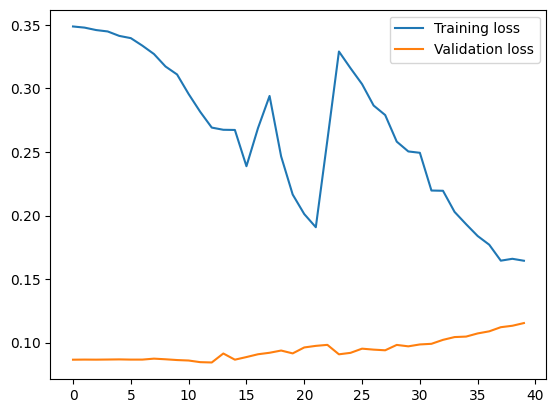

Training loss:  0.16438217811286449
Validation loss:  0.11533019602298737


In [13]:
train(rnn, rnn_config, train_loader, valid_loader)

In [14]:
for name, param in rnn.named_parameters():
    if 'embedding' in name: continue
    print(name, param)

rnn_1.W_xh Parameter containing:
tensor([[ 0.3881,  0.0920, -0.1890,  ...,  0.3052,  0.2075, -0.2805],
        [ 0.0208,  0.4095,  0.1821,  ..., -0.0280, -0.2412, -0.1043],
        [-0.2092, -0.1307,  0.3879,  ...,  0.2664, -0.0233, -0.1475],
        ...,
        [ 0.1089,  0.1633,  0.1340,  ..., -0.1105,  0.5127, -0.0649],
        [ 0.4813,  0.0322, -0.2543,  ..., -0.1976,  0.0997,  0.3527],
        [ 0.0310, -0.1779,  0.0405,  ...,  0.2602,  0.2146, -0.2369]],
       device='cuda:0', requires_grad=True)
rnn_1.W_hh Parameter containing:
tensor([[-0.0262,  0.0972, -0.0909,  ...,  0.0804, -0.2412,  0.0613],
        [-0.1402, -0.0480,  0.2078,  ..., -0.0692, -0.3154, -0.0016],
        [ 0.1513, -0.3412, -0.1608,  ...,  0.1038, -0.1557,  0.0799],
        ...,
        [-0.2847,  0.1715, -0.2143,  ...,  0.1361, -0.1472, -0.0027],
        [ 0.0954, -0.2227, -0.0040,  ...,  0.0321,  0.1179, -0.0107],
        [ 0.0518,  0.1054,  0.3874,  ..., -0.0951, -0.2391, -0.0755]],
       device='cuda:0'

# Evaluation

In [15]:
y_test, y_pred = predict_evaluate(rnn, test_loader)

Accuracy: 0.604


In [16]:
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

         0.0       0.63      0.50      0.56     12500
         1.0       0.59      0.71      0.64     12500

    accuracy                           0.60     25000
   macro avg       0.61      0.60      0.60     25000
weighted avg       0.61      0.60      0.60     25000

